In [1]:
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
from utils import greed_assignment,LAP
from plot_utils import plot_3d
from model import Siren,AssignmentModel,Autoencoder
from data_model import traveling_time_dataset,WaveSpeedDataset,get_latent
from sgld import SGLD
from ot.lp import wasserstein_1d
import matplotlib.pyplot as plt
import copy
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

In [4]:
grid_size=32 #In this notebook, we only illustrate "number of training wavespeed=500, modes=10, grid_size=32 and density=0.2"  For larger grid_size or more modes, more training samples and multi-GPU are recommended.
vmin=0.5
vmax=2.5
n_station=20
n_wavespeed=500
n_wavespeed_test=10
n_mode=10
density=0.2

## Generate dataset

In [5]:
WaveSpeedData=WaveSpeedDataset(n_wavespeed,n_wavespeed_test, grid_size,n_mode,density,vmin,vmax)

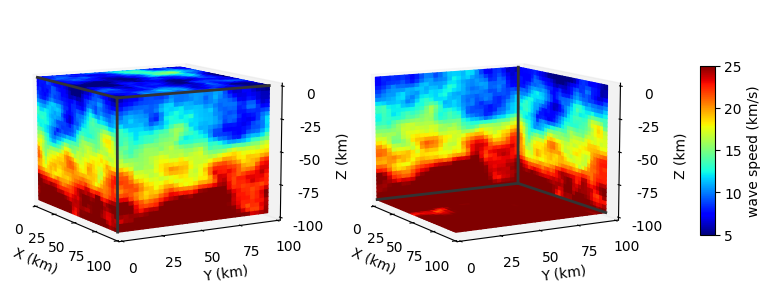

In [7]:
_=plot_3d(WaveSpeedData.data_wavespeed[1],vmin=vmin*10,vmax=vmax*10)

# Train auto encoder

In [23]:
L=4 #latent dim
model_autoencoder=Autoencoder(capacity=128,latent_dims=L).to(device)
ATE_train_loader = torch.utils.data.DataLoader(WaveSpeedData, batch_size=128, shuffle=True)
optimizer = torch.optim.Adam(params=model_autoencoder.parameters(), lr=1e-3)

In [25]:
model_autoencoder.train()
train_loss_avg = []
num_epochs=1000000
print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    #for data in tqdm(ATE_train_loader):
    for data in ATE_train_loader:
        image_batch = data['image'].to(device)
        image_batch=image_batch.unsqueeze(1)
        image_batch_recon,_ = model_autoencoder(image_batch)
        loss = F.mse_loss(image_batch_recon, image_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_avg[-1] += loss.item()
        num_batches += 1
    train_loss_avg[-1] /= num_batches
    if train_loss_avg[-1]<2e-3:
        break
    if epoch%10==0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 1000000] average reconstruction error: 0.002750
Epoch [11 / 1000000] average reconstruction error: 0.002812
Epoch [21 / 1000000] average reconstruction error: 0.002369


0.0007591203


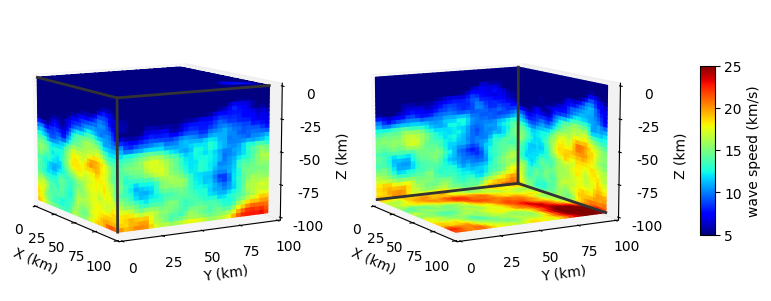

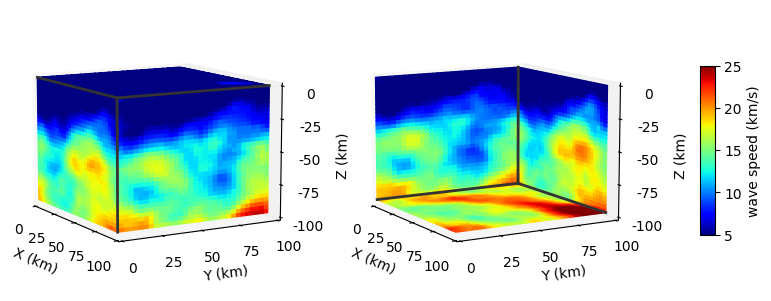

In [27]:
#visualize training wavespeed
model_autoencoder.eval()
id=0
real_c=WaveSpeedData.data_wavespeed[id]
figlist=plot_3d(real_c)
data_input=torch.tensor(WaveSpeedData.data_wavespeed[id]).unsqueeze(0).unsqueeze(0).float().to(device)
re_c=model_autoencoder(data_input)[0].squeeze().clone().detach().cpu().numpy()
figlist=plot_3d(re_c)
print(((re_c-real_c)**2).mean())

0.0011898672


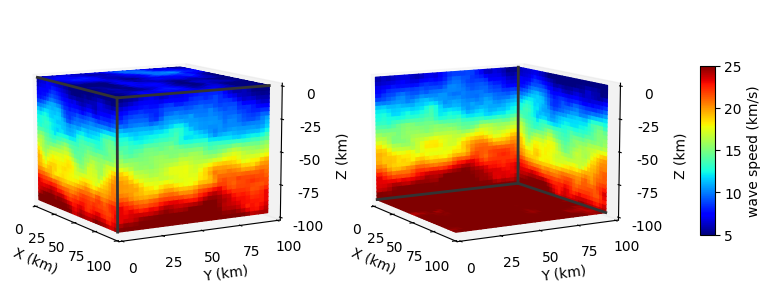

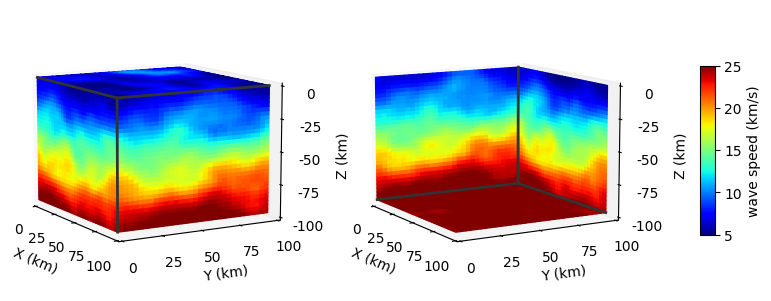

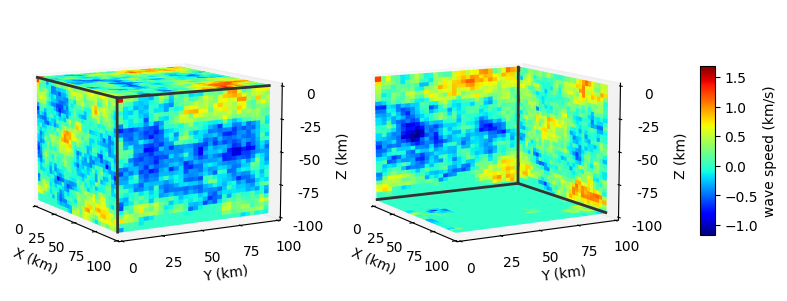

In [29]:
#visualize test plot
model_autoencoder.eval()
id=1
real_c=WaveSpeedData.data_wavespeed_test[id]
figlist=plot_3d(real_c)
data_input=torch.tensor(WaveSpeedData.data_wavespeed_test[id]).unsqueeze(0).unsqueeze(0).float().to(device)
re_c=model_autoencoder(data_input)[0].squeeze().clone().detach().cpu().numpy()
figlist=plot_3d(re_c)
figlist=plot_3d(re_c-real_c)
print(((re_c-real_c)**2).mean())

## Fit traveling time 

In [30]:
L=4
scaler=get_latent(WaveSpeedData,model_autoencoder,device)
z_matrix_scale=scaler.scale_z(scaler.z_matrix)
z_matrix_test_scale=scaler.scale_z(scaler.z_matrix_test)
ttdata=traveling_time_dataset(WaveSpeedData,z_matrix_scale,z_matrix_test_scale,n_station,grid_size)

100%|██████████| 10/10 [00:00<00:00, 14.04it/s]


In [31]:
batch_size_siren=20000
first_omega_0=15
hidden_omega_0=15
model_traveltime= Siren(in_features=3+L, out_features=n_station, hidden_features=512, 
                        hidden_layers=4, outermost_linear=True,first_omega_0=first_omega_0, hidden_omega_0=hidden_omega_0).to(device)
optimizer = torch.optim.Adam(model_traveltime.parameters(), lr=0.00001)
loss_function=torch.nn.MSELoss(reduction='mean')
train_loader = torch.utils.data.DataLoader(ttdata, batch_size=batch_size_siren, shuffle=True,num_workers=20)

In [32]:
# if torch.cuda.device_count() > 1:
#     print("Using", torch.cuda.device_count(), "GPUs!")
#     model_traveltime = torch.nn.DataParallel(model_traveltime)
# model_traveltime.to('cuda')

In [35]:
for epoch in range(100000):
    model_traveltime.train()
    loss_batch = 0
    for data in tqdm(train_loader):
        X = data['in'].float().to(device)
        Y = data['out'].float().to(device)
        # X = data['in'].float().to('cuda')
        # Y = data['out'].float().to('cuda')
        Ypred,_= model_traveltime(X)
        loss = loss_function(Y, Ypred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_batch += loss.item()
    loss_epoch = loss_batch/len(train_loader)
    print(f'Epoch: {epoch:03d}, Train Loss: {loss_epoch:.2E}')
    if loss_epoch<5e-5:
        break

100%|██████████| 3277/3277 [00:35<00:00, 91.85it/s] 


Epoch: 000, Train Loss: 1.87E-04


100%|██████████| 3277/3277 [00:35<00:00, 92.77it/s] 


Epoch: 001, Train Loss: 1.61E-04


100%|██████████| 3277/3277 [00:35<00:00, 93.49it/s] 


Epoch: 002, Train Loss: 1.44E-04


100%|██████████| 3277/3277 [00:35<00:00, 93.02it/s] 


Epoch: 003, Train Loss: 1.30E-04


100%|██████████| 3277/3277 [00:35<00:00, 93.09it/s] 


Epoch: 004, Train Loss: 1.20E-04


100%|██████████| 3277/3277 [00:34<00:00, 93.88it/s] 


Epoch: 005, Train Loss: 1.12E-04


100%|██████████| 3277/3277 [00:35<00:00, 93.06it/s] 


Epoch: 006, Train Loss: 1.05E-04


100%|██████████| 3277/3277 [00:35<00:00, 93.30it/s] 


Epoch: 007, Train Loss: 9.92E-05


100%|██████████| 3277/3277 [00:35<00:00, 93.43it/s] 


Epoch: 008, Train Loss: 9.41E-05


100%|██████████| 3277/3277 [00:35<00:00, 93.54it/s] 


Epoch: 009, Train Loss: 8.99E-05


100%|██████████| 3277/3277 [00:35<00:00, 93.42it/s] 


Epoch: 010, Train Loss: 8.61E-05


100%|██████████| 3277/3277 [00:35<00:00, 93.33it/s] 


Epoch: 011, Train Loss: 8.28E-05


100%|██████████| 3277/3277 [00:35<00:00, 93.08it/s] 


Epoch: 012, Train Loss: 7.98E-05


100%|██████████| 3277/3277 [00:35<00:00, 92.86it/s] 


Epoch: 013, Train Loss: 7.71E-05


100%|██████████| 3277/3277 [00:35<00:00, 92.72it/s] 


Epoch: 014, Train Loss: 7.47E-05


100%|██████████| 3277/3277 [00:35<00:00, 92.64it/s] 


Epoch: 015, Train Loss: 7.23E-05


100%|██████████| 3277/3277 [00:35<00:00, 92.51it/s] 


Epoch: 016, Train Loss: 7.04E-05


100%|██████████| 3277/3277 [00:35<00:00, 92.65it/s] 


Epoch: 017, Train Loss: 6.85E-05


100%|██████████| 3277/3277 [00:35<00:00, 93.05it/s] 


Epoch: 018, Train Loss: 6.67E-05


100%|██████████| 3277/3277 [00:35<00:00, 92.53it/s] 


Epoch: 019, Train Loss: 6.51E-05


100%|██████████| 3277/3277 [00:35<00:00, 92.81it/s] 


Epoch: 020, Train Loss: 6.37E-05


100%|██████████| 3277/3277 [00:35<00:00, 93.14it/s] 


Epoch: 021, Train Loss: 6.23E-05


100%|██████████| 3277/3277 [00:34<00:00, 93.69it/s] 


Epoch: 022, Train Loss: 6.10E-05


100%|██████████| 3277/3277 [00:34<00:00, 93.79it/s] 


Epoch: 023, Train Loss: 5.97E-05


100%|██████████| 3277/3277 [00:35<00:00, 93.34it/s] 


Epoch: 024, Train Loss: 5.86E-05


100%|██████████| 3277/3277 [00:35<00:00, 92.52it/s] 


Epoch: 025, Train Loss: 5.75E-05


100%|██████████| 3277/3277 [00:34<00:00, 93.84it/s] 


Epoch: 026, Train Loss: 5.65E-05


100%|██████████| 3277/3277 [00:34<00:00, 93.85it/s] 


Epoch: 027, Train Loss: 5.55E-05


100%|██████████| 3277/3277 [00:34<00:00, 94.68it/s] 


Epoch: 028, Train Loss: 5.46E-05


100%|██████████| 3277/3277 [00:35<00:00, 93.27it/s] 


Epoch: 029, Train Loss: 5.37E-05


100%|██████████| 3277/3277 [00:35<00:00, 92.72it/s] 


Epoch: 030, Train Loss: 5.29E-05


100%|██████████| 3277/3277 [00:35<00:00, 92.83it/s] 


Epoch: 031, Train Loss: 5.21E-05


100%|██████████| 3277/3277 [00:35<00:00, 92.87it/s] 


Epoch: 032, Train Loss: 5.13E-05


100%|██████████| 3277/3277 [00:34<00:00, 93.69it/s] 


Epoch: 033, Train Loss: 5.06E-05


100%|██████████| 3277/3277 [00:35<00:00, 93.09it/s] 

Epoch: 034, Train Loss: 4.99E-05


In [36]:

# model_traveltime=model_traveltime.module.to(device)
# torch.cuda.empty_cache()
# del X
# del Y

## Generate earthquake dataset

In [37]:
n_earthquake=8
tau_max=0.1 #1=10s
loc_earthquake_index=np.random.randint(grid_size,size=[n_earthquake,3])
tt=ttdata.data_test[id].reshape(n_station,grid_size,grid_size,grid_size)
true_receiver= tt[:,loc_earthquake_index[:,0],loc_earthquake_index[:,1],loc_earthquake_index[:,2]]
loc_earthquake_coord=loc_earthquake_index/(grid_size-1)
time_earthquake = np.random.rand(n_earthquake)*tau_max

## received signal is sorted
true_station_travelingtime=np.zeros_like(true_receiver)
true_station_travelingtime_index=np.zeros_like(true_receiver,dtype=int)
for i in range(n_station):
    true_receiver[i,:]=true_receiver[i,:]+time_earthquake
    true_station_travelingtime[i,:]=np.sort(true_receiver[i,:])
    true_station_travelingtime_index[i,:]=np.argsort(true_receiver[i,:])
z_truth=ttdata.output_test(id)['z']

## Run!

In [39]:
for try_i in range(1000): # usually need 1~5 trials 
    loc_record_list=[]
    lowest_loss=100000
    updata_lr_flag=True    
    L=4 #dimention of the wave speed, for fixed wave speed, L=0
    batch_size=100
    model_traveltime_=copy.deepcopy(model_traveltime).to(device)
    AModel=AssignmentModel(model_traveltime_, n_station, n_earthquake,tau_max,L=L).to(device)
    #AModel=AssignmentModel(model_traveltime_, n_station, n_earthquake,tau_max,L=L,cheat=True,loc_earthquake_truth=loc_earthquake_coord,time_earthquake_truth=time_earthquake,z_truth=z_truth).to(device)
    # In cheat mode, the parameters will be initialized around the grount truth.  This is used to check whether the SIREN and auto-encoder are well trained.
    optimizer = SGLD(AModel.parameters(), lr=0.01,noise=1e-3)
    loc_earthquake_re=AModel.loc_earthquake.detach().clone().cpu().numpy()
    loc_record_list.append(loc_earthquake_re)
    for epoch in range(30):
        loss_batch = 0
        count=0
        for count in range(batch_size):
            i=np.random.randint(n_station) ## update one station at each time 
            out=AModel().T
            outi=out[i,:]
            Y=torch.tensor(true_station_travelingtime[i,:]).float().to(device)
            loss = wasserstein_1d(outi, Y, p=2)
            loss_batch += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_epoch = loss_batch/batch_size
        
        ## change hp
        if loss_epoch<0.001 and updata_lr_flag:
            updata_lr_flag=False
            optimizer = SGLD(AModel.parameters(), lr=0.001,noise=1e-3)            
        
        ## val test
        loc_earthquake_re=AModel.loc_earthquake.detach().clone().cpu().numpy()
        loc_record_list.append(loc_earthquake_re)
        indexB=greed_assignment(loc_earthquake_coord,loc_earthquake_re)  # only check the test perfermance roughly
        loc_error=((loc_earthquake_coord[indexB,:]-loc_earthquake_re)**2).mean()
        time_earthquake_re=AModel.time_earthquake.detach().clone().cpu().numpy()
        time_error=(((time_earthquake[indexB]-time_earthquake_re))**2).mean()
        z=AModel.z.detach().clone().cpu().numpy()
        z_error=np.mean((z-z_truth)**2)
        if loss_epoch <lowest_loss:
            lowest_loss= loss_epoch
            lowest_loss_loc_earthquake_re = loc_earthquake_re
            lowest_loss_time_earthquake_re = time_earthquake_re
            lowest_loss_out = AModel(sort_out=False).clone().detach().cpu().numpy().T
        
        print(f'Try: {try_i:03d},Epoch: {epoch:03d}, Loss: {loss_epoch:.6f}, Loc error: {loc_error:.6f}, Time error: {time_error:.6f}, Z error: {z_error:.6f}')
    if lowest_loss<0.0001:
            break

## training extra epoachs with a small learning rate to get a better reconstruction.
optimizer = SGLD(AModel.parameters(), lr=0.001,noise=1e-4)            
for epoch in range(50):
    loss_batch = 0
    count=0
    for count in range(batch_size):
        i=np.random.randint(n_station) ## update one station at each time 
        out=AModel().T
        outi=out[i,:]
        Y=torch.tensor(true_station_travelingtime[i,:]).float().to(device)
        loss = wasserstein_1d(outi, Y, p=2)
        loss_batch += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_epoch = loss_batch/batch_size
    
    ## val test
    loc_earthquake_re=AModel.loc_earthquake.detach().clone().cpu().numpy()
    loc_record_list.append(loc_earthquake_re)
    indexB=greed_assignment(loc_earthquake_coord,loc_earthquake_re)  # only check the test perfermance roughly
    loc_error=((loc_earthquake_coord[indexB,:]-loc_earthquake_re)**2).mean()
    time_earthquake_re=AModel.time_earthquake.detach().clone().cpu().numpy()
    time_error=(((time_earthquake[indexB]-time_earthquake_re))**2).mean()
    z=AModel.z.detach().clone().cpu().numpy()
    z_error=np.mean((z-z_truth)**2)
    if loss_epoch <lowest_loss:
        lowest_loss= loss_epoch
        lowest_loss_loc_earthquake_re = loc_earthquake_re
        lowest_loss_time_earthquake_re = time_earthquake_re
        lowest_loss_out = AModel(sort_out=False).clone().detach().cpu().numpy().T
    print(f'Try: {try_i:03d},Epoch: {epoch:03d}, Loss: {loss_epoch:.6f}, Loc error: {loc_error:.6f}, Time error: {time_error:.6f}, Z error: {z_error:.6f}')

Try: 000,Epoch: 000, Loss: 0.005024, Loc error: 0.046369, Time error: 0.002277, Z error: 0.006765
Try: 000,Epoch: 001, Loss: 0.002197, Loc error: 0.034324, Time error: 0.002045, Z error: 0.005530
Try: 000,Epoch: 002, Loss: 0.001650, Loc error: 0.021512, Time error: 0.001561, Z error: 0.002386
Try: 000,Epoch: 003, Loss: 0.001663, Loc error: 0.019593, Time error: 0.002272, Z error: 0.001165
Try: 000,Epoch: 004, Loss: 0.001400, Loc error: 0.013104, Time error: 0.002142, Z error: 0.001322
Try: 000,Epoch: 005, Loss: 0.001338, Loc error: 0.013934, Time error: 0.002126, Z error: 0.001232
Try: 000,Epoch: 006, Loss: 0.001508, Loc error: 0.009340, Time error: 0.002171, Z error: 0.001191
Try: 000,Epoch: 007, Loss: 0.000699, Loc error: 0.003018, Time error: 0.001571, Z error: 0.000778
Try: 000,Epoch: 008, Loss: 0.000308, Loc error: 0.002509, Time error: 0.001306, Z error: 0.000379
Try: 000,Epoch: 009, Loss: 0.000096, Loc error: 0.002635, Time error: 0.001131, Z error: 0.000395
Try: 000,Epoch: 010,

Accuracy: 0.9375


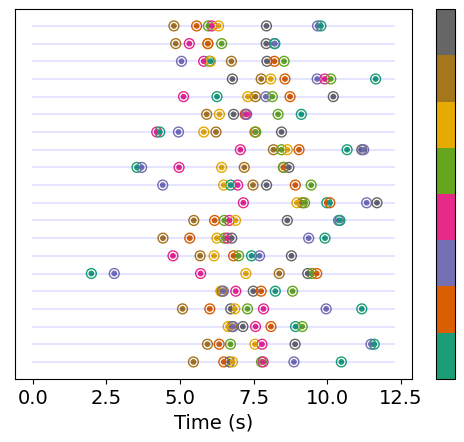

In [40]:
assignment_function=LAP

plt.rcParams.update({'font.size': 14})
indexB=assignment_function(loc_earthquake_coord,loc_earthquake_re)  #to get a order
plt.figure(figsize=(6.4, 4.8))
Crange=range(n_earthquake)
xaxis_max=lowest_loss_out.max()*1.1
cmap = plt.cm.get_cmap('Dark2', n_earthquake)
correct_rate=0
for i in range(n_station):
    yaxis_i=np.ones(n_earthquake)*i
    tx=true_station_travelingtime[i,]
    ti=true_station_travelingtime_index[i,:]
    out=lowest_loss_out[i,:]
    indexBi=assignment_function(out.reshape(-1,1),tx.reshape(-1,1))
    plt.plot([0,xaxis_max*9.5],[i,i],'-b',alpha=0.1)
    plt.scatter(tx*10,yaxis_i,marker='o', facecolors='none',s=50,alpha=1,edgecolors=cmap(ti[Crange]))
    plt.scatter(tx*10,yaxis_i,cmap=cmap,c=indexB[indexBi[Crange]],s=10,alpha=1)
    correct_rate+=np.mean(ti[Crange]==indexB[indexBi[Crange]])
cbar=plt.colorbar()
plt.xlabel('Time (s)')
plt.yticks([])
cbar.ax.tick_params(length=0)
cbar.set_ticks([])
print('Accuracy:',correct_rate/n_station)

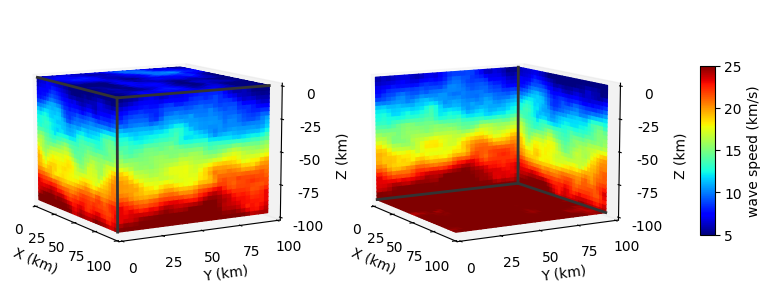

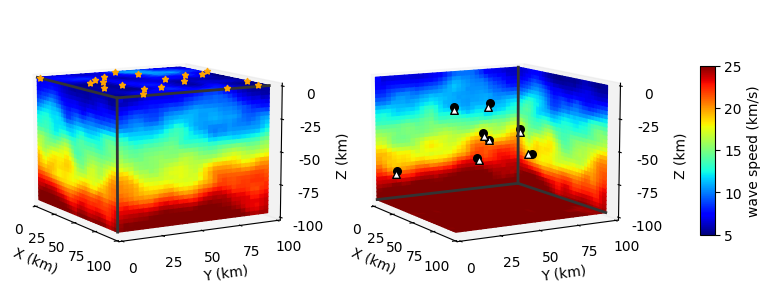

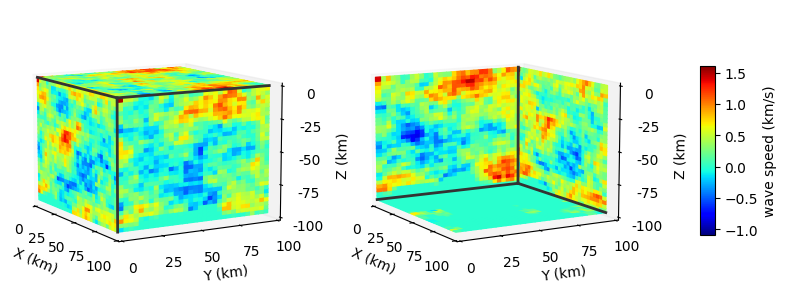

In [42]:

plt.rcParams.update({'font.size': 10})
z0=AModel.z.detach().clone().cpu().numpy()
z_re=scaler.scale_z_inv(z0)
z_re=torch.tensor(z_re).float().to(device)

V_re=model_autoencoder.decoder(z_re.reshape(1,-1)).detach().clone().cpu().numpy()[0][0]
# plot ground truth wave speed 
figlist=plot_3d(real_c)
# plot wave speed reconstrcuction
figlist=plot_3d(V_re)
ax0=figlist[1]
ax1=figlist[2]

#plt.subplots_adjust(wspace=0)
loc_earthquake_re=AModel.loc_earthquake.detach().clone().cpu().numpy()
loc_earthquake=loc_earthquake_coord
cp=plt.cm.get_cmap('Accent', n_earthquake)


ax1.scatter(loc_earthquake_re[:,0]*(grid_size-1),loc_earthquake_re[:,1]*(grid_size-1),-loc_earthquake_re[:,2]*(grid_size-1),s=30,color='black',marker='o',label='Earthquake',depthshade=0,edgecolors='black')
ax1.scatter(loc_earthquake[:,0]*(grid_size-1),loc_earthquake[:,1]*(grid_size-1),-loc_earthquake[:,2]*(grid_size-1),s=30,color='white',marker='^',label='Earthquake',depthshade=0,edgecolors='black')
coord=ttdata.loc_src_coord*grid_size
ax0.scatter3D(coord[:,0],coord[:,1],coord[:,2],s=20,depthshade=0,zorder=1e20,marker=(5, 1),color='orange')
# plot diff
figlist=plot_3d(V_re-real_c)